In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np

from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader

2025-08-11 17:37:26.695002: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 17:37:26.804476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754948246.853429 2249009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754948246.867243 2249009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754948246.954770 2249009 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [13]:
# define this! The rest can remain untouched
molecule = 'h2o'
data_dir = Path(f'./{molecule}_energies_noise_scf_features')
n_atoms = 6

In [14]:
C = [] # xyz coordinates
X = [] # calculated SCF matrix features
Y = [] # calculated energies

for file_path in data_dir.glob('*.npz'):
    data_file = np.load(file_path)
    try:
        C.append(data_file['coords'])
        X.append(data_file['features'])
        Y.append(data_file['energy'])

    except KeyError:
        raise KeyError('wrong key for npz file!')
# you must perform stacking, cannot just convert to array    
N, n_atoms, n_features, channels = np.stack(X).shape
X = np.stack(X).reshape(N, n_atoms, n_features * channels)  # (N, n_atoms, n_features * channels    )
C = np.stack(C)
Y = np.stack(Y)
print(X.shape)
print(Y.shape)

(1000, 3, 70)
(1000,)


In [15]:
def hartree_to_kcal_per_mol(Y):
    return Y * 627.50961

Y = hartree_to_kcal_per_mol(Y)

In [16]:
x_train, x_valtest, y_train, y_valtest, c_train, c_valtest = train_test_split(X, Y, C, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test, c_val, c_test = train_test_split(x_valtest, y_valtest, c_valtest, test_size=0.33, random_state=42)

# 1) compute from TRAIN ONLY
y_mu = y_train.mean()
y_sd = y_train.std() + 1e-8
print("y_mu:", y_mu, "y_sd:", y_sd )

# 2) scale every split with the SAME mu/sd
y_train_s = (y_train - y_mu) / y_sd
y_val_s   = (y_val   - y_mu) / y_sd
y_test_s  = (y_test  - y_mu) / y_sd  # if you have test


print(x_train.shape, y_train.shape, c_train.shape)
print(x_val.shape, y_val.shape, c_val.shape)
print(x_test.shape, y_test.shape, c_test.shape)

y_mu: -47665.70225317801 y_sd: 0.6746812705039306
(700, 3, 70) (700,) (700, 3, 3)
(201, 3, 70) (201,) (201, 3, 3)
(99, 3, 70) (99,) (99, 3, 3)


Of course, we can define the edge features as well

In [17]:
from scipy import sparse 

def build_adjacency_from_xyz(coords, threshold=2.0):
    """
    Given coords: (n_atoms, 3), returns (n_atoms, n_atoms) adjacency matrix
    with 1s where Euclidean distance < threshold and 0 elsewhere (excluding self-loops)
    """
    # n = coords.shape[0]
    dists = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    A = (dists < threshold).astype('float32')
    np.fill_diagonal(A, 0.0)  # remove self-loops
    # print(A)
    return sparse.csr_matrix(A)  # return as sparse matrix for efficiency; spektral expects this forma or np array (more expensive)

class SCFAtomGraphDataset(Dataset):
    def __init__(self, X, Y, C,
                 threshold=2.0, **kwargs):
        """
        Dataset for SCF atom graphs.
        """
        self.X = X.astype('float32')         # (N, n_atoms, n_features, 5)
        self.Y = Y.astype('float32')         # (N,)
        self.C = C.astype('float32')         # (N, n_atoms, 3)
        self.threshold = threshold
        super().__init__(**kwargs)

    def read(self):
        graphs = []
        for x, y, c in zip(self.X, self.Y, self.C):
            A = build_adjacency_from_xyz(c, threshold=self.threshold)  # shape (n_atoms, n_atoms)
            # try this
            graphs.append(Graph(x=x, a=A, y=y))
        return graphs

In [18]:
from spektral.layers import GraphSageConv, GlobalSumPool
'''
tried: GCNConv (only accepts [x,a], cannot accept disjoint batches
GCSConv (shape mismatch)
GINConv (tf error)
GraphSageConv + disable XLA flag + operate on CPU (forced). Both must be present for it work somehow.
'''

class GNNModel(tf.keras.Model):
    def __init__(self, y_mean):
        super().__init__()
        he_init = tf.keras.initializers.HeNormal()

        # ReLU and GeLU layers are best with HeNormal. Default is GlorotUniform, which isn't the most ideal; does not affect performance
        self.conv1 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros') 
        self.conv2 = GraphSageConv(64, activation='relu', kernel_initializer=he_init, bias_initializer='zeros')
        self.pool = GlobalSumPool()
        self.dense = tf.keras.layers.Dense(1, 
                                           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05),
                                           bias_initializer='zeros')

    def call(self, inputs):
        x, a, i = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        x = self.pool([x, i])
        return self.dense(x)


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

def train_GNN(x_train, y_train, c_train,
              x_val, y_val, c_val,
              epochs=10, batch_size=32, threshold=2.5, verbose=0):
    # Create dataset
    train_dataset = SCFAtomGraphDataset(x_train, y_train, c_train, threshold=threshold)

    # tried: SingleLoader (not compatible with N,3,3 data)
    train_loader = DisjointLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = SCFAtomGraphDataset(x_val, y_val, c_val, threshold=threshold)
    val_loader = DisjointLoader(val_dataset, batch_size=batch_size, shuffle=False)


    model = GNNModel(y_mean=y_train.mean())
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=50, min_lr=1e-6)
    model.compile(optimizer='adam', loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    # Train
    history = model.fit(train_loader.load(), steps_per_epoch=train_loader.steps_per_epoch,
                        validation_data=val_loader.load(), validation_steps=val_loader.steps_per_epoch,
                        epochs=epochs, verbose=verbose, callbacks=[lr_scheduler, early_stop])    
    
    return model, history.history

In [20]:
gnn_model, history = train_GNN(x_train=x_train,y_train=y_train_s, c_train=c_train,
                           x_val=x_val,y_val=y_val_s,c_val=c_val,
                           epochs=5000, verbose=1, threshold=1.8)

Epoch 1/5000
14/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9756   

/home/yizhou_chen/miniconda3/envs/base-ml/lib/python3.12/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'SCFAtomGraphDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.0054 - val_loss: 0.7386 - learning_rate: 0.0010
Epoch 2/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0037 - val_loss: 0.7579 - learning_rate: 0.0010
Epoch 3/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0021 - val_loss: 0.7526 - learning_rate: 0.0010
Epoch 4/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0008 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 5/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0002 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 6/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0012 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 7/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0035 - val_loss: 0.7514 - learning_rate: 0.0010
Epoch 8/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0002 - val_loss: 0.7590 - learning_rate: 0.0010
Epoch 9/5000
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0005 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 10/5000
22/22 ━━

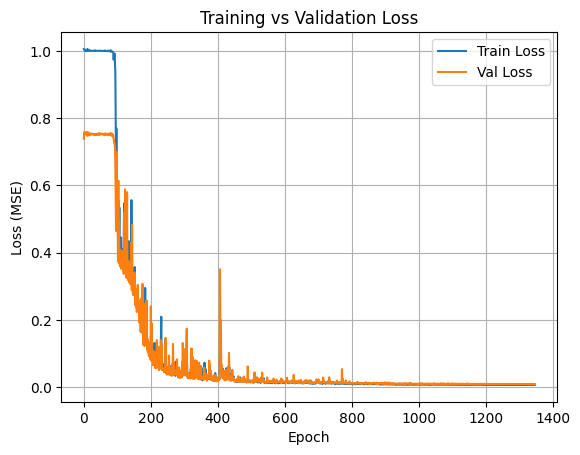

In [21]:
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(x_test.shape, y_test_s.shape)

(99, 3, 70) (99,)


In [23]:
# Create test dataset and loader
test_dataset = SCFAtomGraphDataset(x_test, y_test_s, c_test, threshold=1.8)
test_loader = DisjointLoader(test_dataset, epochs=1, batch_size=32, shuffle=False)

# Evaluate on test set
test_loss = gnn_model.evaluate(test_loader.load(), steps=test_loader.steps_per_epoch)
print(f"Test MSE loss: {test_loss:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109 
Test MSE loss: 0.01


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
y_pred shape: (99,)


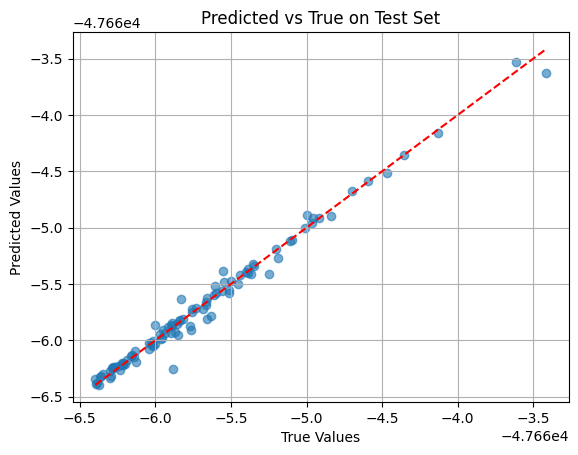

In [24]:
# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = gnn_model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()
y_pred   = (y_pred * y_sd) + y_mu

# 3) Now y_pred.shape == y_true.shape == 99
print("y_pred shape:", y_pred.shape)

# 4) Plot
plt.scatter(y_test, y_pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs True on Test Set")
plt.grid(True)
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

MAE: 4.370783e-02
R²:  0.9854


In [26]:
model_dir = Path('./gnn_model/')
model_dir.mkdir(parents=True, exist_ok=True)

gnn_model.save(model_dir / 'h2o_gnn_model_scf_features_normalise.keras')

## Test on translational invariance

In [19]:
# Evaluation on: CNN, GNN. We have x_test, y_test
from numpy.random import default_rng

def translation(X, offset=10.0):
    '''
    Offset: a (3,) vector (tuple) or a scaler. 
    '''
    off = np.asarray(offset)
    if off.ndim == 0:
        off = np.array([off, off, off])
    return X + off  # broadcasting: (N,n_atoms,3) + (3,) → (N,n_atoms,3)

def rotate_180_y_axis(X):
    R = np.array([[-1, 0, 0],
              [ 0, 1, 0],
              [ 0, 0,-1]])
    return X @ R.T

def permutation(X, seed=None):
    N, n_atoms, xyz = X.shape
    rng = default_rng(seed)          # create a Generator with seed 42
    perm = rng.permutation(n_atoms)
    return X[:, perm, :]

Step 1: save test dataset's energies and xyz coordinates

In [20]:
x_test.shape, y_test.shape, c_test.shape

((99, 3, 70), (99,), (99, 3, 3))

In [21]:
np.save(f'./test_xyz_{molecule}.npy', c_test)

In [27]:
x_test = np.load('./test_scf_h2o_permutated.npy')
y_test = y_test
c_test =np.load('./test_xyz_h2o_permutated.npy')

In [28]:
print(x_test.shape, y_test.shape, c_test.shape)

(99, 3, 70) (99,) (99, 3, 3)


In [29]:
# Create test dataset and loader
test_dataset = SCFAtomGraphDataset(x_test, y_test, c_test, threshold=1.5)

# CRITICAL: **Re‐instantiate** the loader for prediction
pred_loader = DisjointLoader(test_dataset, batch_size=32, epochs=1, shuffle=False)
y_pred = gnn_model.predict(pred_loader.load(), steps=pred_loader.steps_per_epoch).flatten()

from sklearn.metrics import  mean_absolute_error

# y_true and y_pred should be 1D NumPy arrays (e.g., from your test set)
mae = mean_absolute_error(y_test, y_pred)

# print(f"MSE: {mse:.6e}")
print(f"MAE: {mae:.6e}")
print(f"R²:  {r2:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE: 7.125822e+00
R²:  0.9398
